In [1]:
import os
import pickle
import numpy as np
from bayes_opt import BayesianOptimization
from utils.TSDataset import data_load
from utils.models import *

In [2]:
project_dir = os.path.dirname(os.path.abspath('__file__'))

if not os.path.exists(os.path.join(project_dir, 'output')):
    os.makedirs(os.path.join(project_dir, 'output'))

data_path = os.path.join(project_dir, 'data', 'processed', 'BTC-USD-sample.csv')

# Load data
data1, x_scaler, y_scaler = data_load(data_path, x_scaler='minmax', y_scaler='minmax')

In [ ]:
import numpy as np
from bayes_opt import BayesianOptimization

# ── 1) Config ──
data_frame       = data1
scaler           = y_scaler
feature_cols     = ['x1','x2','x3','x4','x5']
target_col       = 'y'
seq2seq          = True
forecast_horizon = 1
strides          = 1

# ── 2) Hyperparameter bounds (including batch_size) ──
pbounds = {
    'filters':       (16, 256),
    'kernel_size':   (2, 8), 
    'lstm_units':    (16, 256),
    'learning_rate': (1e-5, 1e-1),
    'epochs':        (20, 100),
    'window_size':   (50, 3000),
    'batch_size':    (16, 128),
}

# ── 3) Target wrapper ──
def hpo_target(filters, kernel_size, lstm_units, learning_rate,
               epochs, window_size, batch_size):
    return cnn_lstm_model_eval(
        df=data_frame,
        feature_cols=feature_cols,
        target_col=target_col,
        scaler=scaler,
        filters=int(filters),
        kernel_size=int(kernel_size),
        strides=strides,
        lstm_units=int(lstm_units),
        learning_rate=learning_rate,
        epochs=int(epochs),
        window_size=int(window_size),
        batch_size=int(batch_size),
        seq2seq=seq2seq,
        forecast_horizon=forecast_horizon,
        optimize=True
    )

# ── 4) Run Bayesian Optimization ──
optimizer = BayesianOptimization(f=hpo_target, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=5, n_iter = 3)

# ── 5) Pull out the best set (casting ints where needed) ──
best = optimizer.max['params']
best = {k: int(v) if k in pbounds else v for k, v in best.items()}
print("🔍 Best hyperparameters:", best)

|   iter    |  target   | batch_... |  epochs   |  filters  | kernel... | learni... | lstm_u... | window... |
-------------------------------------------------------------------------------------------------------------
| 1         | -8.519e+0 | 57.95     | 96.06     | 191.7     | 5.592     | 0.01561   | 53.44     | 64.52     |
| 2         | -9.6e+05  | 113.0     | 68.09     | 185.9     | 2.124     | 0.09699   | 215.8     | 103.1     |
| 3         | -2.695e+0 | 36.36     | 34.67     | 89.02     | 5.149     | 0.0432    | 85.89     | 203.0     |
| 4         | -1.995e+0 | 31.62     | 43.37     | 103.9     | 4.736     | 0.07852   | 63.92     | 178.6     |
| 5         | -3.487e+0 | 82.35     | 23.72     | 161.8     | 3.023     | 0.006515  | 243.7     | 291.4     |
| 6         | -1.272e+0 | 45.8      | 83.1      | 105.7     | 6.398     | 0.001634  | 19.55     | 57.33     |
| 7         | -1.331e+0 | 58.89     | 99.95     | 186.8     | 2.494     | 0.02287   | 53.74     | 53.81     |
| 8       

In [3]:
df = data1
feature_cols = ['x1','x2','x3','x4','x5']
target_col = 'y'

scaler = y_scaler

filters = 105
window_size = 129
kernel_size = 3
strides = 1
lstm_units = 20
learning_rate = 0.0016
epochs = 80

mse, mae, history, model, y_pred, y_true = cnn_lstm_model_eval(
    df = df,
    feature_cols = feature_cols,
    target_col = target_col,
    scaler = scaler,
    filters = filters,
    window_size = window_size,
    kernel_size = kernel_size,
    strides = strides,
    lstm_units = lstm_units,
    learning_rate = learning_rate,
    epochs = epochs,
    forecast_horizon=1,
    optimize = False
)

13923.4443359375
102.45396423339844


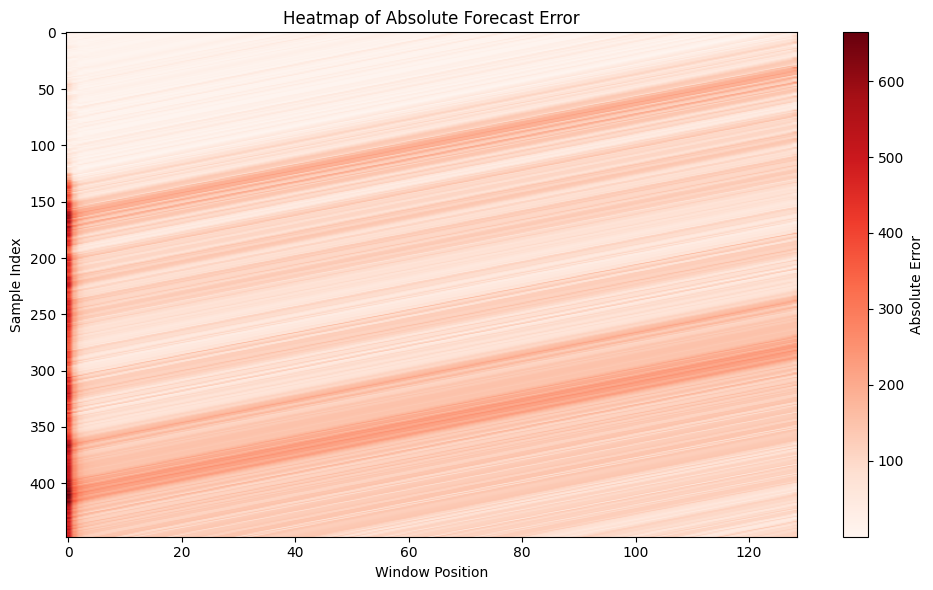

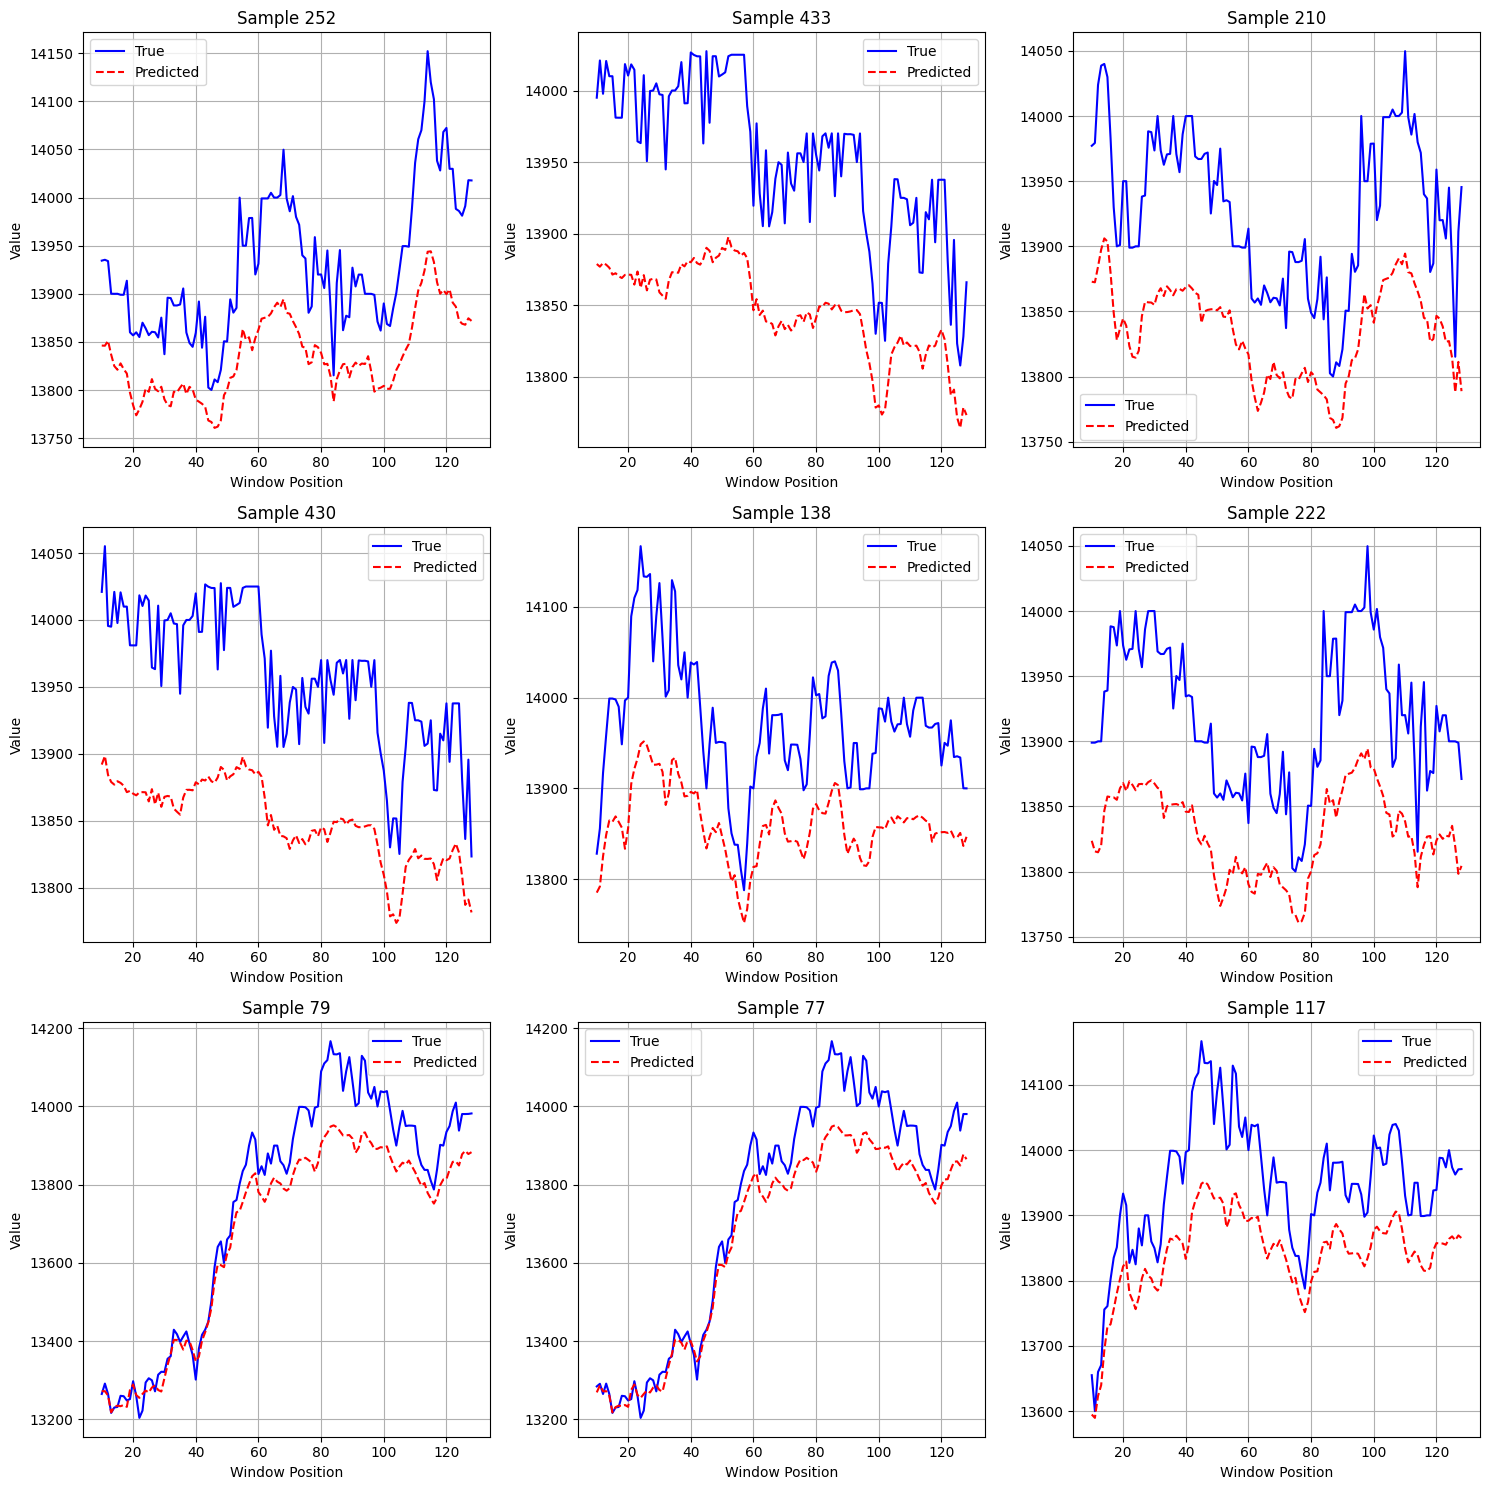

In [ ]:
import random
import matplotlib.pyplot as plt

print(mse)
print(mae)


y_true_copy = y_true.squeeze(-1)
y_pred_copy = y_pred.squeeze(-1)

sample_indices = random.sample(range(y_true.shape[0]), 9)

plt.figure(figsize=(15, 15))
time = np.arange(10, 129)
for i, idx in enumerate(sample_indices):
    plt.subplot(3, 3, i+1)
    plt.plot(time, y_true_copy[idx][10:], label='True', color='blue')
    plt.plot(time, y_pred_copy[idx][10:], label='Predicted', linestyle='--', color='red')
    plt.title(f'Sample {idx}')
    plt.xlabel('Window Position')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from bayes_opt import BayesianOptimization

# ── 1) Config ──
data_frame       = data1
scaler           = y_scaler
feature_cols     = ['x1','x2','x3','x4','x5']
target_col       = 'y'
seq2seq          = True
forecast_horizon = 30
strides          = 1

# ── 2) Hyperparameter bounds (including batch_size) ──
pbounds = {
    'filters':       (16, 256),
    'kernel_size':   (2, 8), 
    'lstm_units':    (16, 256),
    'learning_rate': (1e-5, 1e-1),
    'epochs':        (20, 100),
    'window_size':   (50, 3000),
    'batch_size':    (16, 128),
}

# ── 3) Target wrapper ──
def hpo_target(filters, kernel_size, lstm_units, learning_rate,
               epochs, window_size, batch_size):
    return cnn_lstm_model_eval(
        df=data_frame,
        feature_cols=feature_cols,
        target_col=target_col,
        scaler=scaler,
        filters=int(filters),
        kernel_size=int(kernel_size),
        strides=strides,
        lstm_units=int(lstm_units),
        learning_rate=learning_rate,
        epochs=int(epochs),
        window_size=int(window_size),
        batch_size=int(batch_size),
        seq2seq=seq2seq,
        forecast_horizon=forecast_horizon,
        optimize=True
    )

# ── 4) Run Bayesian Optimization ──
optimizer = BayesianOptimization(f=hpo_target, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=5, n_iter = 3)

# ── 5) Pull out the best set (casting ints where needed) ──
best = optimizer.max['params']
best = {k: int(v) if k in pbounds else v for k, v in best.items()}
print("🔍 Best hyperparameters:", best)

In [23]:
df = data1
feature_cols = ['x1','x2','x3','x4','x5']
target_col = 'y'

scaler = y_scaler

filters = 105
window_size = 129
kernel_size = 3
strides = 1
lstm_units = 20
learning_rate = 0.0016
epochs = 80

mse, mae, history, model, y_pred, y_true = cnn_lstm_model_eval(
    df = df,
    feature_cols = feature_cols,
    target_col = target_col,
    scaler = scaler,
    filters = filters,
    window_size = window_size,
    kernel_size = kernel_size,
    strides = strides,
    lstm_units = lstm_units,
    learning_rate = learning_rate,
    epochs = epochs,
    forecast_horizon=5,
    optimize = False
)

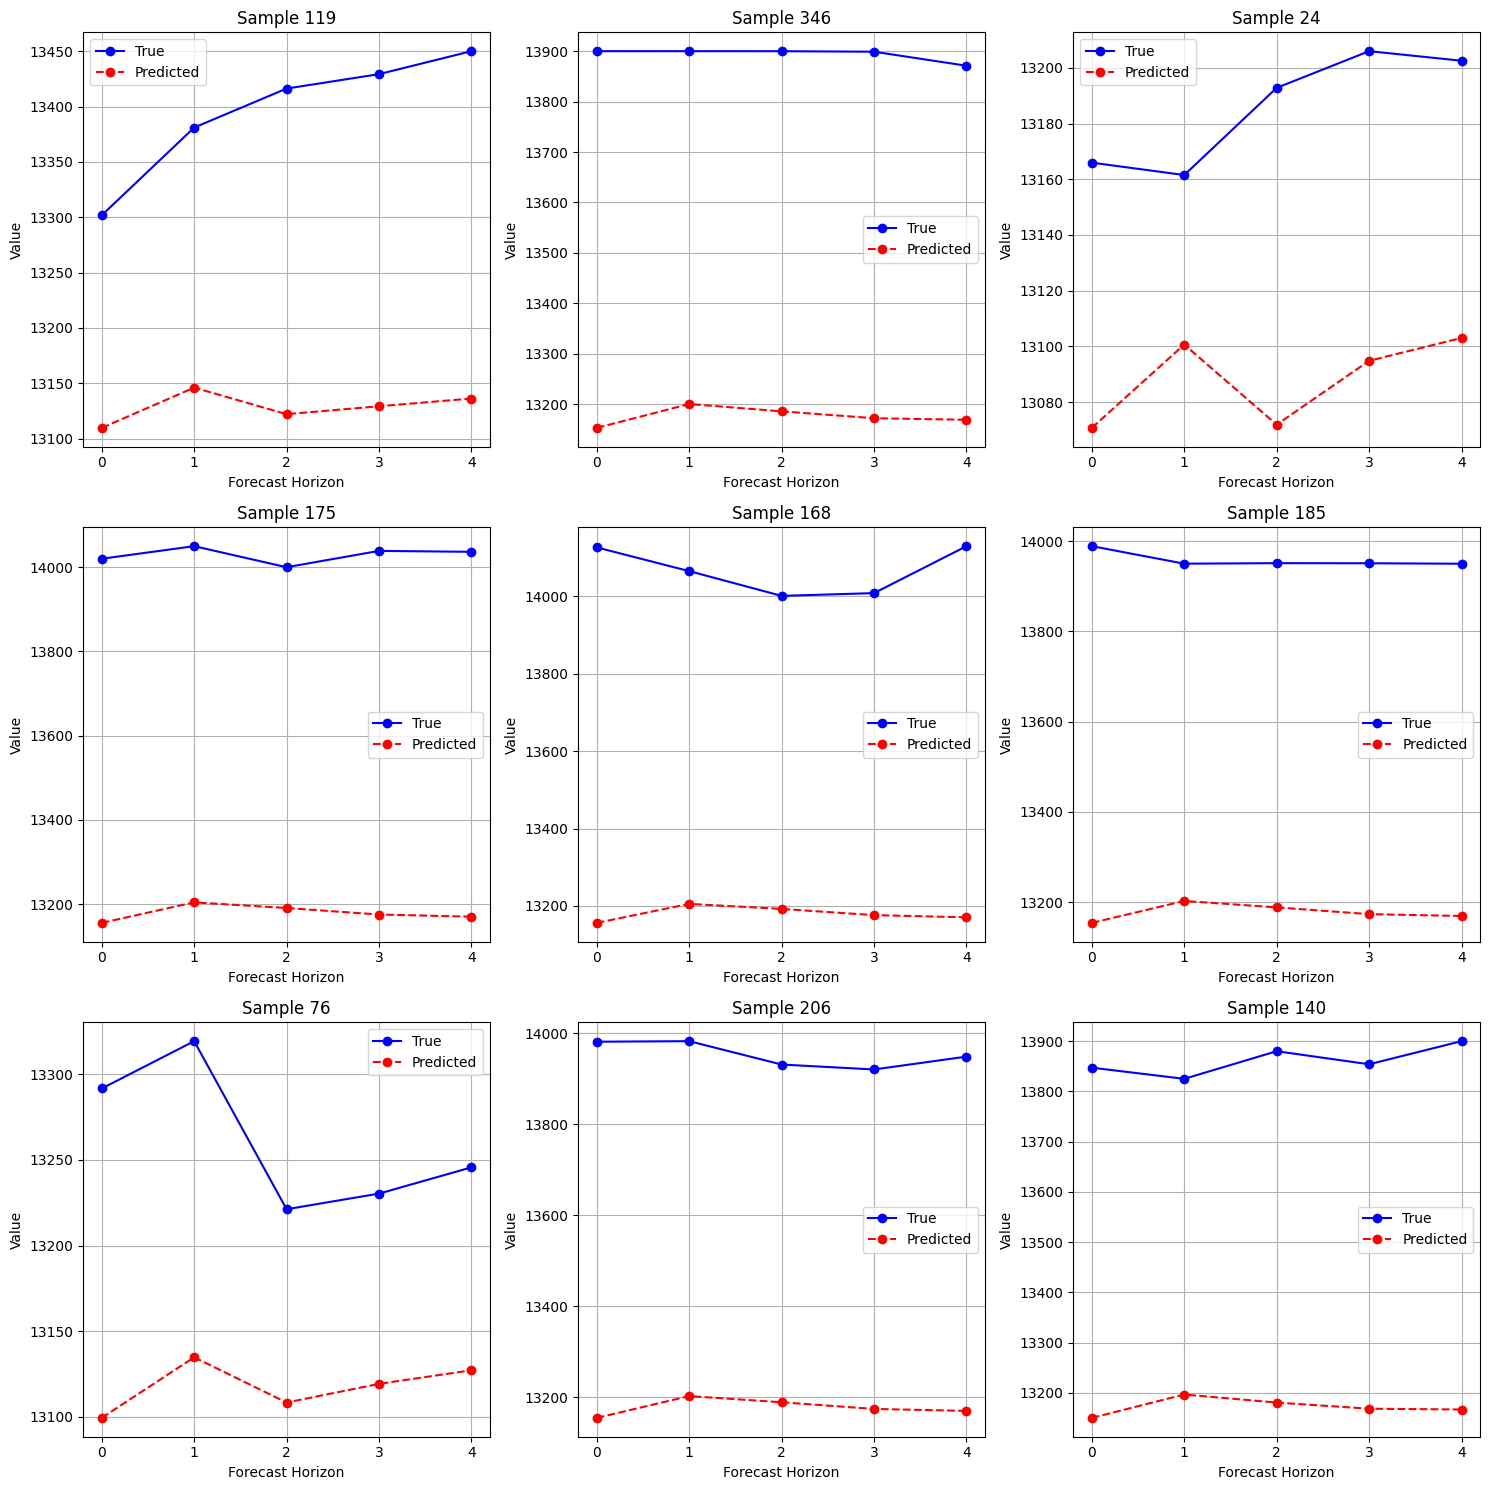

In [48]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
# Select 9 random samples
sample_indices = random.sample(range(y_true.shape[0]), 9)

plt.figure(figsize=(15, 15))
for i, idx in enumerate(sample_indices):
    plt.subplot(3, 3, i+1)
    # Plot the 5 predicted values against the 5 actual values
    plt.plot(range(5), y_true[idx, 0, :], 'o-', label='True', color='blue')
    plt.plot(range(5), y_pred[idx, 0, :], 'o--', label='Predicted', color='red')
    plt.title(f'Sample {idx}')
    plt.xlabel('Forecast Horizon')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    # Set x-axis ticks to show each forecast step
    plt.xticks(range(5))

plt.tight_layout()
plt.show()
